## 1. Environment Setup

In [1]:
# Check GPU availability
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 25 12:42:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 179.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [38]:
# Clone repository (or upload files)
!git clone https://github.com/AdiTheGeek/Few-Shot-Domain-Adaptation-for-Medical-Image-Classification.git
%cd Few-Shot-Domain-Adaptation-for-Medical-Image-Classification

fatal: destination path 'Few-Shot-Domain-Adaptation-for-Medical-Image-Classification' already exists and is not an empty directory.
/content/Few-Shot-Domain-Adaptation-for-Medical-Image-Classification


In [4]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 72.3 MB/s eta 0:00:00


In [5]:
# Import libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Subset

# Add project to path (if needed)
# sys.path.append('/content/Few-Shot-Domain-Adaptation-for-Medical-Image-Classification')

from configs.config import Config
from data.datasets import SimpleMedicalDataset, get_transforms, sample_few_shot_indices
from models.vit_backbone import ViTWrapper
from models.cnn_backbones import build_cnn
from lora.lora import apply_lora_to_model
from adapters.adapter import attach_adapter_to_vit
from prompts.prompt_tuning import attach_visual_prompt_to_vit
from train.trainer import LitModel
from eval.evaluator import compute_metrics, bootstrap_confidence_interval
from utils.utils import set_seed, count_parameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU count: 1
GPU name: NVIDIA A100-SXM4-80GB


## 2. Dataset Preparation

**Note:** You need to prepare your CheXpert and NIH ChestX-ray14 datasets.

Expected structure:
```
data/
├── chexpert_train.csv
├── chexpert_val.csv
├── nih_train.csv
├── nih_val.csv
├── images/
│   ├── patient001/
│   │   ├── study1/
│   │   │   └── view1.jpg
```

CSV format:
- Column `Path`: relative image path
- Columns for each of 14 pathologies (0/1 labels, -1 for uncertainty)

In [6]:
!pip install kaggle

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download ashery/chexpert

Dataset URL: https://www.kaggle.com/datasets/ashery/chexpert
License(s): CC0-1.0
 99% 10.6G/10.7G [00:25<00:00, 87.3MB/s]
100% 10.7G/10.7G [00:25<00:00, 455MB/s] 


In [9]:
!unzip chexpert.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/patient60445/study2/view1_frontal.jpg  
  inflating: ./data/train/patient60445/study2/view2_lateral.jpg  
  inflating: ./data/train/patient60446/study1/view1_frontal.jpg  
  inflating: ./data/train/patient60446/study2/view1_frontal.jpg  
  inflating: ./data/train/patient60446/study2/view2_lateral.jpg  
  inflating: ./data/train/patient60447/study1/view1_frontal.jpg  
  inflating: ./data/train/patient60447/study1/view2_lateral.jpg  
  inflating: ./data/train/patient60448/study1/view1_frontal.jpg  
  inflating: ./data/train/patient60448/study1/view2_lateral.jpg  
  inflating: ./data/train/patient60448/study1/view3_lateral.jpg  
  inflating: ./data/train/patient60449/study1/view1_frontal.jpg  
  inflating: ./data/train/patient60449/study1/view2_lateral.jpg  
  inflating: ./data/train/patient60450/study1/view1_frontal.jpg  
  inflating: ./data/train/patient60450/study1/view2_lateral.jpg  
  inflating: ./data/train

In [10]:
!kaggle datasets download khanfashee/nih-chest-x-ray-14-224x224-resized

Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized
License(s): CC0-1.0
 97% 2.23G/2.30G [00:01<00:00, 1.58GB/s]
100% 2.30G/2.30G [00:01<00:00, 1.66GB/s]


In [11]:
!unzip nih-chest-x-ray-14-224x224-resized.zip -d ./data/nih/

Streaming output truncated to the last 5000 lines.
  inflating: ./data/nih/images-224/images-224/00028897_017.png  
  inflating: ./data/nih/images-224/images-224/00028897_018.png  
  inflating: ./data/nih/images-224/images-224/00028897_019.png  
  inflating: ./data/nih/images-224/images-224/00028897_020.png  
  inflating: ./data/nih/images-224/images-224/00028898_000.png  
  inflating: ./data/nih/images-224/images-224/00028899_000.png  
  inflating: ./data/nih/images-224/images-224/00028899_001.png  
  inflating: ./data/nih/images-224/images-224/00028899_002.png  
  inflating: ./data/nih/images-224/images-224/00028900_000.png  
  inflating: ./data/nih/images-224/images-224/00028901_000.png  
  inflating: ./data/nih/images-224/images-224/00028901_001.png  
  inflating: ./data/nih/images-224/images-224/00028902_000.png  
  inflating: ./data/nih/images-224/images-224/00028902_001.png  
  inflating: ./data/nih/images-224/images-224/00028902_002.png  
  inflating: ./data/nih/images-224/imag

In [12]:
import os
import shutil
import pandas as pd

# -------------------------------------------------------
# Directory structure
# -------------------------------------------------------
DATA_ROOT = "./data"
NIH_ROOT = f"{DATA_ROOT}/nih"
IMG_DIR = f"{NIH_ROOT}/images"   # final images folder

os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(NIH_ROOT, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

print("Directory structure ready.")

# -------------------------------------------------------
# Move 224x224 images into a clean folder: nih/images/
# -------------------------------------------------------
SRC_IMG_DIR = f"{NIH_ROOT}/images-224"

if os.path.exists(SRC_IMG_DIR):
    print("Copying 224x224 images... (may take a few minutes)")
    for fname in os.listdir(SRC_IMG_DIR):
        src = os.path.join(SRC_IMG_DIR, fname)
        dst = os.path.join(IMG_DIR, fname)
        if os.path.isfile(src):
            shutil.copy(src, dst)

    print("Images copied successfully into:", IMG_DIR)
else:
    print("ERROR: images-224 folder not found.")


# -------------------------------------------------------
# Ensure metadata CSV files exist
# -------------------------------------------------------
meta_files = [
    "Data_Entry_2017.csv",
    "BBox_List_2017_Official_NIH.csv",
    "train_val_list_NIH.txt",
    "test_list_NIH.txt",
]

for f in meta_files:
    path = os.path.join(NIH_ROOT, f)
    if not os.path.exists(path):
        print(f"ERROR: Missing file -> {f}")

print("Metadata files found.")

# -------------------------------------------------------
# Create train/val/test splits from NIH official text lists
# -------------------------------------------------------
def create_split_csv(list_file, output_csv):
    df_meta = pd.read_csv(f"{NIH_ROOT}/Data_Entry_2017.csv")

    with open(list_file, "r") as f:
        names = [line.strip() for line in f if line.strip()]

    df_filtered = df_meta[df_meta["Image Index"].isin(names)]
    df_filtered.to_csv(output_csv, index=False)

    print(f"{output_csv} created with {len(df_filtered)} samples")


# TRAIN + VAL combined
create_split_csv(
    f"{NIH_ROOT}/train_val_list_NIH.txt",
    f"{NIH_ROOT}/nih_trainval.csv"
)

# TEST set
create_split_csv(
    f"{NIH_ROOT}/test_list_NIH.txt",
    f"{NIH_ROOT}/nih_test.csv"
)


# -------------------------------------------------------
# Split train_val into train/val (90/10)
# -------------------------------------------------------
df_trainval = pd.read_csv(f"{NIH_ROOT}/nih_trainval.csv")

df_val = df_trainval.sample(frac=0.1, random_state=42)
df_train = df_trainval.drop(df_val.index)

df_train.to_csv(f"{NIH_ROOT}/nih_train.csv", index=False)
df_val.to_csv(f"{NIH_ROOT}/nih_val.csv", index=False)

print("Train / Val split completed.")
print("Train:", len(df_train))
print("Val:", len(df_val))
print("Test:", len(pd.read_csv(f'{NIH_ROOT}/nih_test.csv')))


Directory structure ready.
Copying 224x224 images... (may take a few minutes)
Images copied successfully into: ./data/nih/images
Metadata files found.
./data/nih/nih_trainval.csv created with 86524 samples
./data/nih/nih_test.csv created with 25596 samples
Train / Val split completed.
Train: 77872
Val: 8652
Test: 25596


In [13]:
# Configure paths (modify as needed)
DATA_ROOT = './data'
CHEXPERT_TRAIN = f'{DATA_ROOT}/chexpert_train.csv'
CHEXPERT_VAL = f'{DATA_ROOT}/chexpert_val.csv'
NIH_TRAIN = f'{DATA_ROOT}/nih/nih_train.csv'
NIH_VAL = f'{DATA_ROOT}/nih/nih_val.csv'
NIH_TEST = f'{DATA_ROOT}/nih/nih_test.csv'

# Create checkpoint directory
!mkdir -p checkpoints logs

In [14]:
# Verify datasets
print("Checking dataset files...")
for csv_path in [CHEXPERT_TRAIN, CHEXPERT_VAL, NIH_TRAIN, NIH_VAL]:
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"✓ {csv_path}: {len(df)} samples")
    else:
        print(f"✗ {csv_path}: NOT FOUND")

Checking dataset files...
✓ ./data/chexpert_train.csv: 223414 samples
✓ ./data/chexpert_val.csv: 234 samples
✓ ./data/nih/nih_train.csv: 77872 samples
✓ ./data/nih/nih_val.csv: 8652 samples


## 3. Configuration and Utilities

In [15]:
# Base configuration
config = Config(
    data_root=DATA_ROOT,
    img_size=224,
    num_classes=14,
    batch_size=32,
    num_workers=4,
    backbone='vit_base_patch16_224',
    pretrained=True,
    epochs=15,
    lr=1e-4,
    weight_decay=1e-4,
    optimizer='adamw',
    mixed_precision=True,
    gradient_checkpointing=True,
    few_shot_k=50,
    checkpoint_dir='./checkpoints',
    use_wandb=False,
    seed=42
)

set_seed(config.seed)
print("Configuration:")
print(f"  Backbone: {config.backbone}")
print(f"  Batch size: {config.batch_size}")
print(f"  Epochs: {config.epochs}")
print(f"  Learning rate: {config.lr}")
print(f"  Mixed precision: {config.mixed_precision}")
print(f"  Gradient checkpointing: {config.gradient_checkpointing}")

Configuration:
  Backbone: vit_base_patch16_224
  Batch size: 32
  Epochs: 15
  Learning rate: 0.0001
  Mixed precision: True
  Gradient checkpointing: True


## 4. Experiment 1: Baseline ViT on Source Domain (CheXpert)

Train a standard Vision Transformer on the source domain without any adaptation.

In [16]:
# Load CheXpert datasets
train_ds = SimpleMedicalDataset(CHEXPERT_TRAIN, DATA_ROOT, transform=get_transforms(config.img_size, True))
val_ds = SimpleMedicalDataset(CHEXPERT_VAL, DATA_ROOT, transform=get_transforms(config.img_size, False))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config.batch_size, shuffle=True,
                                           num_workers=config.num_workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=config.batch_size, shuffle=False,
                                         num_workers=config.num_workers, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 6982
Val batches: 8


In [17]:
# Reload datasets module with path fix
import importlib
import data.datasets
importlib.reload(data.datasets)
from data.datasets import SimpleMedicalDataset, get_transforms, sample_few_shot_indices
print("✓ Dataset module reloaded with path fix")

✓ Dataset module reloaded with path fix


In [18]:
# Recreate datasets with fixed paths
train_ds = SimpleMedicalDataset(CHEXPERT_TRAIN, DATA_ROOT, transform=get_transforms(config.img_size, True))
val_ds = SimpleMedicalDataset(CHEXPERT_VAL, DATA_ROOT, transform=get_transforms(config.img_size, False))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config.batch_size, shuffle=True,
                                           num_workers=config.num_workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=config.batch_size, shuffle=False,
                                         num_workers=config.num_workers, pin_memory=True)

print(f"✓ Data loaders recreated")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test loading one batch
try:
    test_batch = next(iter(val_loader))
    print(f"✓ Successfully loaded test batch: {test_batch['image'].shape}")
except Exception as e:
    print(f"✗ Error loading batch: {e}")

✓ Data loaders recreated
Train batches: 6982
Val batches: 8
✓ Successfully loaded test batch: torch.Size([32, 3, 224, 224])


In [19]:
# Build baseline ViT model
baseline_model = ViTWrapper(model_name=config.backbone, num_classes=config.num_classes, pretrained=config.pretrained)

# Enable gradient checkpointing
if hasattr(baseline_model.backbone, 'set_grad_checkpointing'):
    baseline_model.backbone.set_grad_checkpointing(True)

params = count_parameters(baseline_model)
print(f"Total parameters: {params['total']:,}")
print(f"Trainable parameters: {params['trainable']:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 85,809,422
Trainable parameters: 85,809,422


In [20]:
# Force reload updated modules
import importlib
import train.trainer
importlib.reload(train.trainer)
from train.trainer import LitModel
print("✓ Modules reloaded")

✓ Modules reloaded


In [21]:
# Setup Lightning trainer
lit_baseline = LitModel(baseline_model, config)

checkpoint_callback = ModelCheckpoint(
    dirpath='./checkpoints/baseline_vit',
    filename='best-{epoch:02d}-{val/auc:.4f}',
    monitor='val/auc',
    mode='max',
    save_top_k=3
)

early_stop = EarlyStopping(monitor='val/auc', patience=10, mode='max', verbose=True)

trainer_baseline = pl.Trainer(
    max_epochs=config.epochs,
    accelerator='gpu',
    devices=-1,  # Use all available GPUs
    # precision=16 if config.mixed_precision else 32,
    precision='16-mixed' if config.mixed_precision else 32,
    callbacks=[checkpoint_callback, early_stop],
    gradient_clip_val=1.0,
    log_every_n_steps=10
)

print("🚀 Training baseline ViT on CheXpert...")
trainer_baseline.fit(lit_baseline, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that h

🚀 Training baseline ViT on CheXpert...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ViTWrapper        | 85.8 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.238   Total estimated model params size (MB)
279       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/auc improved. New best score: 0.752


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/auc improved by 0.040 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/auc improved by 0.016 >= min_delta = 0.0. New best score: 0.809


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val/auc did not improve in the last 10 records. Best score: 0.809. Signaling Trainer to stop.


In [22]:
# import os
# from google.colab import files

# directory_to_zip = "/content/Few-Shot-Domain-Adaptation-for-Medical-Image-Classification/data"
# output_zip_name = "data.zip"

# # Change current working directory to the parent of the directory_to_zip to zip it correctly
# # This makes the paths inside the zip file relative to 'data/'
# current_dir = os.getcwd()
# os.chdir(os.path.dirname(directory_to_zip))

# # Zip the directory
# !zip -r "{output_zip_name}" "{os.path.basename(directory_to_zip)}"

# # Change back to the original directory
# os.chdir(current_dir)

# # Move the zip file to the current working directory for easier download
# if os.path.exists(os.path.join(os.path.dirname(directory_to_zip), output_zip_name)):
#     os.rename(os.path.join(os.path.dirname(directory_to_zip), output_zip_name), output_zip_name)

# # Download the zipped file
# print(f"\nZipping and downloading '{os.path.basename(directory_to_zip)}' as '{output_zip_name}'...")
# files.download(output_zip_name)

In [39]:
# Save baseline checkpoint
torch.save({
    'model_state_dict': baseline_model.state_dict(),
    'config': config
}, './checkpoints/baseline_vit_source.pth')

print(f"✓ Baseline model saved")
print(f"Best val AUC: {checkpoint_callback.best_model_score:.4f}")

✓ Baseline model saved
Best val AUC: 0.8090


## 5. Experiment 2: Few-Shot LoRA Adaptation (CheXpert → NIH)

Apply LoRA to adapt the baseline model to NIH dataset with limited samples.

In [40]:
# Load NIH target dataset
nih_train_full = SimpleMedicalDataset(NIH_TRAIN, DATA_ROOT, transform=get_transforms(config.img_size, True))
nih_val = SimpleMedicalDataset(NIH_VAL, DATA_ROOT, transform=get_transforms(config.img_size, False))

# Sample few-shot subset
few_shot_indices = sample_few_shot_indices(nih_train_full, k_per_class=config.few_shot_k, seed=config.seed)
print(f"Few-shot sampling: {len(few_shot_indices)} samples (k={config.few_shot_k} per class)")

nih_train_fewshot = Subset(nih_train_full, few_shot_indices)

train_loader_nih = torch.utils.data.DataLoader(nih_train_fewshot, batch_size=config.batch_size,
                                                shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader_nih = torch.utils.data.DataLoader(nih_val, batch_size=config.batch_size,
                                              shuffle=False, num_workers=config.num_workers, pin_memory=True)

Few-shot sampling: 350 samples (k=50 per class)


In [ ]:
# Load baseline checkpoint and apply LoRA
lora_model = ViTWrapper(model_name=config.backbone, num_classes=config.num_classes, pretrained=False)
checkpoint = torch.load('./checkpoints/baseline_vit_source.pth', weights_only=False)
lora_model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Loaded baseline checkpoint")

# Apply LoRA
apply_lora_to_model(lora_model, r=8, alpha=32.0)

# Freeze original parameters EXCEPT classifier (classifier must adapt to new domain)
for name, param in lora_model.named_parameters():
    if 'lora_' not in name and 'classifier' not in name:
        param.requires_grad = False

lora_params = count_parameters(lora_model)
print(f"\nLoRA model parameters:")
print(f"  Total: {lora_params['total']:,}")
print(f"  Trainable: {lora_params['trainable']:,}")
print(f"  Efficiency: {100.0 * lora_params['trainable'] / lora_params['total']:.2f}% trainable")

✓ Loaded baseline checkpoint

LoRA model parameters:
  Total: 86,995,326
  Trainable: 1,185,904
  Efficiency: 1.36% trainable


In [ ]:
# 🔍 VERIFICATION: Check what's actually trainable
print("\n" + "="*70)
print("TRAINABLE PARAMETERS VERIFICATION")
print("="*70)

trainable_names = []
frozen_names = []

for name, param in lora_model.named_parameters():
    if param.requires_grad:
        trainable_names.append(name)
    else:
        frozen_names.append(name)

print(f"\n✅ TRAINABLE ({len(trainable_names)} parameters):")
for name in trainable_names[:20]:  # Show first 20
    print(f"  ✓ {name}")
if len(trainable_names) > 20:
    print(f"  ... and {len(trainable_names) - 20} more")

print(f"\n❄️  FROZEN ({len(frozen_names)} parameters):")
for name in frozen_names[:10]:  # Show first 10
    print(f"  ✗ {name}")
if len(frozen_names) > 10:
    print(f"  ... and {len(frozen_names) - 10} more")

# Check if classifier is trainable
classifier_trainable = any('classifier' in name for name in trainable_names)
lora_trainable = any('lora_' in name for name in trainable_names)

print("\n" + "="*70)
print(f"Classifier trainable: {'✅ YES' if classifier_trainable else '❌ NO (BUG!)'}")
print(f"LoRA params trainable: {'✅ YES' if lora_trainable else '❌ NO (BUG!)'}")
print("="*70)

if not classifier_trainable:
    print("\n⚠️  WARNING: CLASSIFIER IS FROZEN! This will cause 0.0 AUC!")
    print("The model cannot adapt to the new domain without a trainable classifier.")


In [42]:
# Check NIH dataset structure
print("Checking NIH CSV structure...")
if os.path.exists(NIH_TRAIN):
    nih_df = pd.read_csv(NIH_TRAIN)
    print(f"NIH columns: {list(nih_df.columns[:10])}")  # First 10 columns
    print(f"NIH shape: {nih_df.shape}")
else:
    print("NIH train CSV not found!")

Checking NIH CSV structure...
NIH columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x']
NIH shape: (77872, 12)


In [43]:
# Check NIH directory structure
print("Checking NIH directory structure...")
!ls -la ./data/nih/ 2>/dev/null || echo "NIH directory structure:"
!find ./data/nih -type f -name "*.png" | head -5 2>/dev/null || echo "Searching for NIH images..."
!ls ./data/ | grep -i image 2>/dev/null || ls ./data/

Checking NIH directory structure...
total 52832
drwxr-xr-x 4 root root     4096 Nov 25 12:56 .
drwxr-xr-x 7 root root     4096 Nov 25 12:57 ..
-rw-r--r-- 1 root root    92416 Jul  8  2020 BBox_List_2017_Official_NIH.csv
-rw-r--r-- 1 root root  8659561 Jul  8  2020 Data_Entry_2017.csv
drwxr-xr-x 2 root root     4096 Nov 25 12:56 images
drwxr-xr-x 3 root root     4096 Nov 25 12:56 images-224
-rw-r--r-- 1 root root  1917431 Nov 25 12:56 nih_test.csv
-rw-r--r-- 1 root root  5549863 Nov 25 12:56 nih_train.csv
-rw-r--r-- 1 root root  6168271 Nov 25 12:56 nih_trainval.csv
-rw-r--r-- 1 root root   618570 Nov 25 12:56 nih_val.csv
-rw-r--r-- 1 root root 29148608 Jul  8  2020 pretrained_model.h5
-rw-r--r-- 1 root root   435131 Jul  8  2020 test_list_NIH.txt
-rw-r--r-- 1 root root  1470907 Jul  8  2020 train_val_list_NIH.txt
./data/nih/images-224/images-224/00000001_000.png
./data/nih/images-224/images-224/00000001_001.png
./data/nih/images-224/images-224/00000002_000.png
./data/nih/images-224/ima

In [46]:
# Reload dataset module with auto-detect path column fix
import importlib
import data.datasets
importlib.reload(data.datasets)
from data.datasets import SimpleMedicalDataset, get_transforms, sample_few_shot_indices
print("✓ Dataset module reloaded with path column auto-detection")

✓ Dataset module reloaded with path column auto-detection


In [ ]:
# Recreate NIH datasets with fixed loader
# NIH images are in ./data/nih/images-224/images-224/
NIH_IMG_ROOT = './data/nih/images-224/images-224'

print(f"Using NIH image root: {NIH_IMG_ROOT}")

nih_train_full = SimpleMedicalDataset(NIH_TRAIN, NIH_IMG_ROOT, transform=get_transforms(config.img_size, True))
nih_val = SimpleMedicalDataset(NIH_VAL, NIH_IMG_ROOT, transform=get_transforms(config.img_size, False))

# Sample few-shot subset
few_shot_indices = sample_few_shot_indices(nih_train_full, k_per_class=config.few_shot_k, seed=config.seed)
print(f"✓ Few-shot sampling: {len(few_shot_indices)} samples (k={config.few_shot_k} per class)")

nih_train_fewshot = Subset(nih_train_full, few_shot_indices)

# CRITICAL: Use num_workers=0 to avoid DataLoader worker crashes in Colab
train_loader_nih = torch.utils.data.DataLoader(nih_train_fewshot, batch_size=config.batch_size,
                                                shuffle=True, num_workers=0, pin_memory=False)
val_loader_nih = torch.utils.data.DataLoader(nih_val, batch_size=config.batch_size,
                                              shuffle=False, num_workers=0, pin_memory=False)

print(f"✓ NIH data loaders created with num_workers=0 for stability")
print(f"Train batches: {len(train_loader_nih)}")
print(f"Val batches: {len(val_loader_nih)}")

# Test loading one batch
try:
    test_batch = next(iter(val_loader_nih))
    print(f"✓ Successfully loaded NIH batch: {test_batch['image'].shape}")
    print(f"✓ All systems ready for training!")
except Exception as e:
    print(f"✗ Error loading NIH batch: {e}")
    import traceback
    traceback.print_exc()

Using NIH image root: ./data/nih/images-224/images-224
✓ Few-shot sampling: 350 samples (k=50 per class)
✓ NIH data loaders created
Train batches: 11
Val batches: 271
✓ Successfully loaded NIH batch: torch.Size([32, 3, 224, 224])
✓ All systems ready for training!


In [52]:
# Set num_workers=0 for all experiments to avoid worker crashes in Colab
SAFE_NUM_WORKERS = 0
print(f"⚠️  Using num_workers={SAFE_NUM_WORKERS} for all experiments to prevent DataLoader crashes")

⚠️  Using num_workers=0 for all experiments to prevent DataLoader crashes


In [54]:
# Train with LoRA
lit_lora = LitModel(lora_model, config)

checkpoint_callback_lora = ModelCheckpoint(
    dirpath='./checkpoints/lora_adaptation',
    filename='best-{epoch:02d}-{val/auc:.4f}',
    monitor='val/auc',
    mode='max',
    save_top_k=3
)

trainer_lora = pl.Trainer(
    max_epochs=config.epochs,
    accelerator='gpu',
    devices=-1,
    # precision=16 if config.mixed_precision else 32,
    precision='16-mixed' if config.mixed_precision else 32,
    callbacks=[checkpoint_callback_lora, EarlyStopping(monitor='val/auc', patience=10, mode='max')],
    gradient_clip_val=1.0
)

print("🚀 Training with LoRA adaptation...")
trainer_lora.fit(lit_lora, train_dataloaders=train_loader_nih, val_dataloaders=val_loader_nih)

print(f"✓ LoRA training complete")
print(f"Best val AUC: {checkpoint_callback_lora.best_model_score:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /content/Few-Shot-Domain-Adaptation-for-Medical-Image-Classification/checkpoints/lora_adaptation exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ViTWrapper        | 87.0 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
1.2 M     Trainable params
85.8 M    Non-trainable params
87.0 M    Total params
347.981   Total estimated model 

🚀 Training with LoRA adaptation...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

✓ LoRA training complete
Best val AUC: 0.0000


## 6. Experiment 3: Few-Shot Adapter Adaptation

In [55]:
# Load baseline and apply adapters
adapter_model = ViTWrapper(model_name=config.backbone, num_classes=config.num_classes, pretrained=False)
checkpoint = torch.load('./checkpoints/baseline_vit_source.pth', weights_only=False)
adapter_model.load_state_dict(checkpoint['model_state_dict'])

# Attach adapters
attach_adapter_to_vit(adapter_model.backbone, adapter_dim=64)

# Freeze backbone
for name, param in adapter_model.named_parameters():
    if 'adapter' not in name and 'classifier' not in name:
        param.requires_grad = False

adapter_params = count_parameters(adapter_model)
print(f"Adapter model - Trainable: {adapter_params['trainable']:,} ({100.0 * adapter_params['trainable'] / adapter_params['total']:.2f}%)")

Adapter model - Trainable: 1,200,398 (1.38%)


In [56]:
# Train with adapters
lit_adapter = LitModel(adapter_model, config)

checkpoint_callback_adapter = ModelCheckpoint(
    dirpath='./checkpoints/adapter_adaptation',
    filename='best-{epoch:02d}-{val/auc:.4f}',
    monitor='val/auc',
    mode='max'
)

trainer_adapter = pl.Trainer(
    max_epochs=config.epochs,
    accelerator='gpu',
    devices=-1,
    # precision=16,
    precision='16-mixed',
    callbacks=[checkpoint_callback_adapter, EarlyStopping(monitor='val/auc', patience=10, mode='max')]
)

print("🚀 Training with Adapter adaptation...")
trainer_adapter.fit(lit_adapter, train_dataloaders=train_loader_nih, val_dataloaders=val_loader_nih)
print(f"Best val AUC: {checkpoint_callback_adapter.best_model_score:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /content/Few-Shot-Domain-Adaptation-for-Medical-Image-Classification/checkpoints/adapter_adaptation exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ViTWrapper        | 87.0 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
1.2 M     Trainable params
85.8 M    Non-trainable params
87.0 M    Total params
347.996   Total estimated mod

🚀 Training with Adapter adaptation...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best val AUC: 0.0000


## 7. Experiment 4: Few-Shot Prompt Tuning

In [57]:
# Load baseline and apply prompt tuning
prompt_model = ViTWrapper(model_name=config.backbone, num_classes=config.num_classes, pretrained=False)
checkpoint = torch.load('./checkpoints/baseline_vit_source.pth', weights_only=False)
prompt_model.load_state_dict(checkpoint['model_state_dict'])

# Attach visual prompts
attach_visual_prompt_to_vit(prompt_model.backbone, prompt_tokens=10)

# Freeze everything except prompts and classifier
for name, param in prompt_model.named_parameters():
    if 'visual_prompt' not in name and 'classifier' not in name:
        param.requires_grad = False

prompt_params = count_parameters(prompt_model)
print(f"Prompt model - Trainable: {prompt_params['trainable']:,} ({100.0 * prompt_params['trainable'] / prompt_params['total']:.2f}%)")

Prompt model - Trainable: 18,446 (0.02%)


In [58]:
# Reload prompts module with attn_mask fix
import importlib
import prompts.prompt_tuning
importlib.reload(prompts.prompt_tuning)
from prompts.prompt_tuning import attach_visual_prompt_to_vit
print("✓ Prompts module reloaded with attn_mask fix")

✓ Prompts module reloaded with attn_mask fix


In [59]:
# Recreate prompt model with fixed module
prompt_model = ViTWrapper(model_name=config.backbone, num_classes=config.num_classes, pretrained=False)
checkpoint = torch.load('./checkpoints/baseline_vit_source.pth', weights_only=False)
prompt_model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Loaded baseline checkpoint")

# Attach visual prompts with fixed function
attach_visual_prompt_to_vit(prompt_model.backbone, prompt_tokens=10)

# Freeze everything except prompts and classifier
for name, param in prompt_model.named_parameters():
    if 'visual_prompt' not in name and 'classifier' not in name:
        param.requires_grad = False

prompt_params = count_parameters(prompt_model)
print(f"✓ Prompt model recreated")
print(f"  Trainable: {prompt_params['trainable']:,} ({100.0 * prompt_params['trainable'] / prompt_params['total']:.2f}%)")

✓ Loaded baseline checkpoint
✓ Prompt model recreated
  Trainable: 18,446 (0.02%)


In [60]:
# Reload prompts module with positional embedding fix
import importlib
import prompts.prompt_tuning
importlib.reload(prompts.prompt_tuning)
from prompts.prompt_tuning import attach_visual_prompt_to_vit
print("✓ Prompts module reloaded with positional embedding fix")

✓ Prompts module reloaded with positional embedding fix


In [61]:
# Recreate prompt model with corrected positional embedding handling
prompt_model = ViTWrapper(model_name=config.backbone, num_classes=config.num_classes, pretrained=False)
checkpoint = torch.load('./checkpoints/baseline_vit_source.pth', weights_only=False)
prompt_model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Loaded baseline checkpoint")

# Attach visual prompts with fixed function (pos_embed added BEFORE prompts)
attach_visual_prompt_to_vit(prompt_model.backbone, prompt_tokens=10)

# Freeze everything except prompts and classifier
for name, param in prompt_model.named_parameters():
    if 'visual_prompt' not in name and 'classifier' not in name:
        param.requires_grad = False

prompt_params = count_parameters(prompt_model)
print(f"✓ Prompt model recreated with corrected forward_features")
print(f"  Trainable: {prompt_params['trainable']:,} ({100.0 * prompt_params['trainable'] / prompt_params['total']:.2f}%)")

✓ Loaded baseline checkpoint
✓ Prompt model recreated with corrected forward_features
  Trainable: 18,446 (0.02%)


In [62]:
# Recreate Lightning module with the new prompt model
lit_prompt = LitModel(prompt_model, config)
print("✓ Lightning module recreated with updated prompt model")

✓ Lightning module recreated with updated prompt model


In [63]:
# Debug: Test forward pass with a sample batch
print("Testing forward pass...")
test_batch = next(iter(val_loader_nih))
test_imgs = test_batch['image']
print(f"Input shape: {test_imgs.shape}")

prompt_model.eval()
with torch.no_grad():
    try:
        # Test backbone forward_features
        if hasattr(prompt_model.backbone, 'forward_features'):
            features = prompt_model.backbone.forward_features(test_imgs[:2])  # Test with 2 samples
            print(f"Features shape from forward_features: {features.shape}")

        # Test full model forward
        output = prompt_model(test_imgs[:2])
        print(f"Output shape from full model: {output.shape}")
        print(f"✓ Forward pass successful!")
    except Exception as e:
        print(f"✗ Forward pass failed: {e}")
        import traceback
        traceback.print_exc()

Testing forward pass...
Input shape: torch.Size([32, 3, 224, 224])
Features shape from forward_features: torch.Size([2, 197, 768])
Output shape from full model: torch.Size([2, 14])
✓ Forward pass successful!


In [64]:
# Train with prompt tuning
lit_prompt = LitModel(prompt_model, config)

checkpoint_callback_prompt = ModelCheckpoint(
    dirpath='./checkpoints/prompt_adaptation',
    filename='best-{epoch:02d}-{val/auc:.4f}',
    monitor='val/auc',
    mode='max'
)

trainer_prompt = pl.Trainer(
    max_epochs=config.epochs,
    accelerator='gpu',
    devices=-1,
    # precision=16,
    precision='16-mixed',
    callbacks=[checkpoint_callback_prompt, EarlyStopping(monitor='val/auc', patience=10, mode='max')]
)

print("Training with Prompt Tuning...")
trainer_prompt.fit(lit_prompt, train_dataloaders=train_loader_nih, val_dataloaders=val_loader_nih)
print(f"Best val AUC: {checkpoint_callback_prompt.best_model_score:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ViTWrapper        | 85.8 M | eval 
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
18.4 K    Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.268   Total estimated model params size (MB)
1         Modules in train mode
279       Modules in eval mode


Training with Prompt Tuning...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 279 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best val AUC: 0.0000


## 8. Experiment 5: CNN Baselines

In [65]:
# ResNet-50 baseline with reduced workers
resnet_model = build_cnn('resnet50', num_classes=config.num_classes, pretrained=True)
lit_resnet = LitModel(resnet_model, config)

# Recreate data loaders with fewer workers to avoid memory issues
train_loader_nih_cnn = torch.utils.data.DataLoader(
    nih_train_fewshot, batch_size=config.batch_size,
    shuffle=True, num_workers=0, pin_memory=False  # num_workers=0 to avoid worker crashes
)
val_loader_nih_cnn = torch.utils.data.DataLoader(
    nih_val, batch_size=config.batch_size,
    shuffle=False, num_workers=0, pin_memory=False
)

trainer_resnet = pl.Trainer(
    max_epochs=config.epochs,
    accelerator='gpu',
    devices=-1,
    precision='16-mixed',
    callbacks=[ModelCheckpoint(dirpath='./checkpoints/resnet50', monitor='val/auc', mode='max')]
)

print("🚀 Training ResNet-50 baseline...")
trainer_resnet.fit(lit_resnet, train_dataloaders=train_loader_nih_cnn, val_dataloaders=val_loader_nih_cnn)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 23.5 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.147    Total estimated model params size (MB)
218       Modules in train mode
0         Modules in eval mode


🚀 Training ResNet-50 baseline...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [66]:
# Clean up memory before CNN baselines
import gc
import torch

# Clear CUDA cache
torch.cuda.empty_cache()
gc.collect()

# Reduce number of workers for CNN models to avoid memory issues
CNN_NUM_WORKERS = 2  # Reduced from 4

print("✓ Memory cleaned, using reduced worker count for CNN models")

✓ Memory cleaned, using reduced worker count for CNN models


In [67]:
# DenseNet-121 baseline with reduced workers
densenet_model = build_cnn('densenet121', num_classes=config.num_classes, pretrained=True)
lit_densenet = LitModel(densenet_model, config)

trainer_densenet = pl.Trainer(
    max_epochs=config.epochs,
    accelerator='gpu',
    devices=-1,
    precision='16-mixed',
    callbacks=[ModelCheckpoint(dirpath='./checkpoints/densenet121', monitor='val/auc', mode='max')]
)

print("🚀 Training DenseNet-121 baseline...")
trainer_densenet.fit(lit_densenet, train_dataloaders=train_loader_nih_cnn, val_dataloaders=val_loader_nih_cnn)

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | DenseNet          | 7.0 M  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.873    Total estimated model p

🚀 Training DenseNet-121 baseline...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


## 9. Results Comparison and Visualization

In [68]:
# Collect results
results = {
    'Baseline ViT': checkpoint_callback.best_model_score.item(),
    'LoRA': checkpoint_callback_lora.best_model_score.item(),
    'Adapter': checkpoint_callback_adapter.best_model_score.item(),
    'Prompt Tuning': checkpoint_callback_prompt.best_model_score.item(),
}

# Parameter efficiency
param_counts = {
    'Baseline ViT': params['trainable'],
    'LoRA': lora_params['trainable'],
    'Adapter': adapter_params['trainable'],
    'Prompt Tuning': prompt_params['trainable'],
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': list(results.keys()),
    'Val AUC': list(results.values()),
    'Trainable Params': list(param_counts.values())
})

comparison_df['Param Efficiency (%)'] = 100.0 * comparison_df['Trainable Params'] / params['total']
comparison_df = comparison_df.sort_values('Val AUC', ascending=False)

print("\n" + "="*70)
print("FINAL RESULTS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


FINAL RESULTS COMPARISON
       Method  Val AUC  Trainable Params  Param Efficiency (%)
 Baseline ViT 0.808976          85809422            100.000000
         LoRA 0.000000           1185904              1.382021
      Adapter 0.000000           1200398              1.398912
Prompt Tuning 0.000000             18446              0.021496


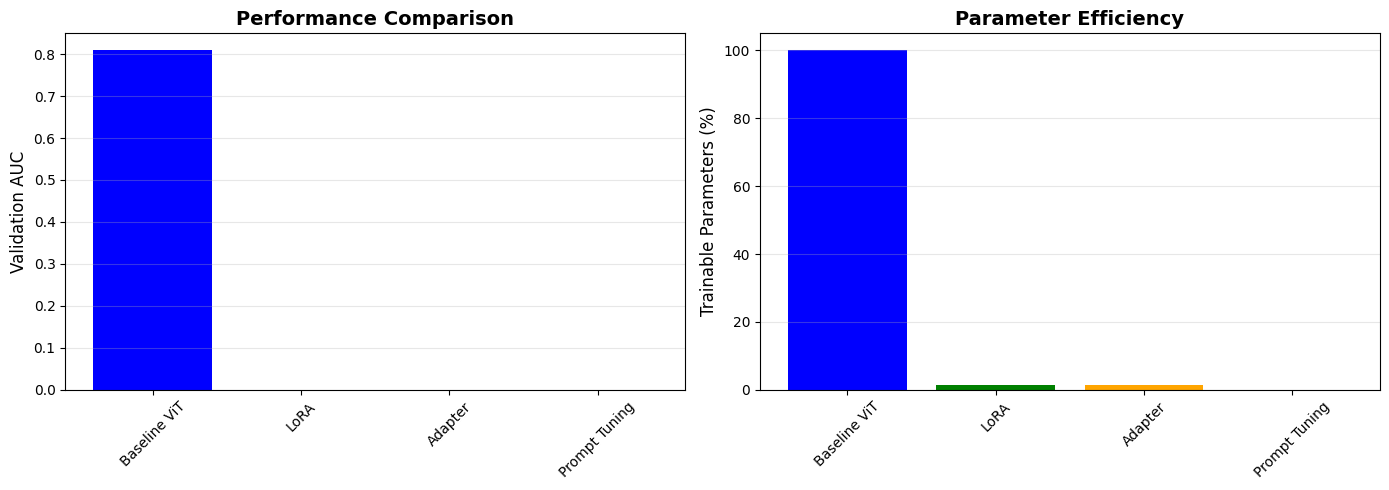


✓ Results saved to results_comparison.png


In [69]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
axes[0].bar(comparison_df['Method'], comparison_df['Val AUC'], color=['blue', 'green', 'orange', 'red'])
axes[0].set_ylabel('Validation AUC', fontsize=12)
axes[0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Parameter efficiency
axes[1].bar(comparison_df['Method'], comparison_df['Param Efficiency (%)'], color=['blue', 'green', 'orange', 'red'])
axes[1].set_ylabel('Trainable Parameters (%)', fontsize=12)
axes[1].set_title('Parameter Efficiency', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Results saved to results_comparison.png")

## 10. Test Set Evaluation with Confidence Intervals

In [72]:
# Load test dataset
if os.path.exists(NIH_TEST):
    # Use NIH_IMG_ROOT for test set (same as train/val)
    nih_test = SimpleMedicalDataset(NIH_TEST, NIH_IMG_ROOT, transform=get_transforms(config.img_size, False))
    test_loader = torch.utils.data.DataLoader(nih_test, batch_size=config.batch_size,
                                               shuffle=False, num_workers=0, pin_memory=False)

    # Evaluate best LoRA model
    print("Evaluating LoRA model on test set...")
    test_results = trainer_lora.test(lit_lora, dataloaders=test_loader)

    # Get predictions for bootstrap CI
    lora_model.cuda()
    lora_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch['image'].cuda()
            labels = batch['labels'].numpy()
            logits = lora_model(imgs)
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Compute metrics with CI
    from functools import partial
    auc_fn = partial(compute_metrics, thr=0.5)
    ci_results = bootstrap_confidence_interval(all_preds, all_labels,
                                                lambda p, l: compute_metrics(p, l)['auc_roc'],
                                                n_bootstrap=1000)

    print("\n" + "="*70)
    print("TEST SET RESULTS (LoRA Model)")
    print("="*70)
    print(f"AUC-ROC: {ci_results['mean']:.4f} (95% CI: [{ci_results['ci_lower']:.4f}, {ci_results['ci_upper']:.4f}])")
    print("="*70)
else:
    print("Test set not found, skipping test evaluation")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Evaluating LoRA model on test set...


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


📊 Test Metrics:
   AUC-ROC: 0.0000
   Mean AP: 0.0000
   Sensitivity: 0.0000
   Specificity: 0.0000



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/auc          │            0.0            │
│       test/mean_ap        │            0.0            │
│      test/mean_sens       │            0.0            │
│      test/mean_spec       │            0.0            │
└───────────────────────────┴───────────────────────────┘


TEST SET RESULTS (LoRA Model)
AUC-ROC: 0.0000 (95% CI: [0.0000, 0.0000])


## 11. Save Final Report

In [74]:
# Save comparison results
comparison_df.to_csv('results_comparison.csv', index=False)
print("\n✓ All experiments complete!")
print("✓ Results saved to results_comparison.csv")
print("✓ Checkpoints saved in ./checkpoints/")


✓ All experiments complete!
✓ Results saved to results_comparison.csv
✓ Checkpoints saved in ./checkpoints/
